In [1]:
import os
import sys
from pathlib import Path
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt


project_dir = Path.cwd().parent
sys.path.append(str(project_dir / 'src'))
from utils import fasta_to_str, check_homologous_sequences
from blast import BLAST
from global_alignment import GlobalAlignment
from visualization import plot_alignment, plot_frequency

np.random.seed(23)

### Human Chr 7 and Chimp Chr 7

In this notebook, we will attempt to find regions of alignment in the first 6M base pairs of the Human chr 7 and Chimp chr 7.  We first use a custom implementation of BLAST (basic local alignment search tool) to find regions of local alignment.  Then, using another custom implementation of a global alignment algorithm, we confirm alignment from the previous step.  Finally, we visualize the alignmet of the homologous regions.

Download the necessary files from Ensembl

https://ftp.ensembl.org/pub/release-112/fasta/homo_sapiens/dna/

https://ftp.ensembl.org/pub/release-113/fasta/pan_troglodytes/dna/

In [2]:
file_folder = r"Documents\Datasets\genomes\human"
filename = r"Homo_sapiens.GRCh38.dna_rm.chromosome.7.fa"
filepath = os.path.join(file_folder, filename)

hum = fasta_to_str(filepath)
print(len(hum))

7 dna_rm:chromosome chromosome:GRCh38:7:1:159345973:1 REF
159345973


In [3]:
file_folder = r"Documents\Datasets\genomes\chimp"
filename = r"Pan_troglodytes.Pan_tro_3.0.dna_rm.chromosome.7.fa"
filepath = os.path.join(file_folder, filename)

chimp = fasta_to_str(filepath)
print(len(chimp))

7 dna_rm:chromosome chromosome:Pan_tro_3.0:7:1:166211670:1 REF
166211670


In [4]:
# Take the first 6M base pairs to find alignments
hum_slice = hum[:6_000_000]
chimp_slice = chimp[:6_000_000]

del hum
del chimp

### 1) BLAST

In [5]:
blast = BLAST(hum_slice, chimp_slice)

In [6]:
blast.seed(kmers=30, kmer_length=10)

TTTCATTCAC ---- 5 ---- 8
GCACAGGCCG ---- 7 ---- 8
CTCAGGGCCT ---- 25 ---- 22
GGCCACGCTT ---- 4 ---- 6
ACAGTGGCAC ---- 12 ---- 8
AGATGATCTA ---- 2 ---- 2
CAGGGCCCAT ---- 7 ---- 7
CCTGTAACCG ---- 3 ---- 2
CTTGGGCTCC ---- 7 ---- 12
CTATTGGCAA ---- 1 ---- 1
CTGTGCCCAG ---- 18 ---- 27
GTAGCGTGAA ---- 2 ---- 2
GCAACCTGGC ---- 5 ---- 4
GTATTAAATA ---- 6 ---- 4
AGTTTGGAAT ---- 3 ---- 5
CACGAGCATT ---- 1 ---- 4
GTTTGGTGAA ---- 7 ---- 7
CTAGAGCTTT ---- 3 ---- 2
ACCTATAAAA ---- 3 ---- 5
TGTGCAAAAG ---- 2 ---- 4
TTTCATCTTT ---- 13 ---- 10
GTCATTTAAA ---- 3 ---- 4
AGAACAGGGA ---- 11 ---- 13
CCTTCCTGTT ---- 10 ---- 15
GCCGCTCTCA ---- 2 ---- 2
GGGAGTGGAG ---- 12 ---- 16
TTCTTGAATT ---- 1 ---- 1
TCCTGATGAT ---- 3 ---- 1
GGTACAGTGC ---- 2 ---- 3
GTGATTTCTC ---- 10 ---- 8
30 kmers stored.
29 total rejects.


In [7]:
blast.extend_seeds(perc_homology=0.8, min_match_len=20_000, threshold=1_000)

kmer: CTCAGGGCCT  match length: 23110
seq1[3244893:3268004]  seq2[2402298:2425409]
kmer: GGCCACGCTT  match length: 23129
seq1[2736055:2759185]  seq2[1866243:1889373]
kmer: CTTGGGCTCC  match length: 21506
seq1[5036538:5058045]  seq2[4179578:4201085]
kmer: CTGTGCCCAG  match length: 21751
seq1[1678451:1700203]  seq2[792259:814011]
kmer: CTGTGCCCAG  match length: 26359
seq1[4478571:4504931]  seq2[3644631:3670991]
kmer: AGTTTGGAAT  match length: 22485
seq1[4384103:4406589]  seq2[3548433:3570919]
kmer: TGTGCAAAAG  match length: 23110
seq1[3244900:3268011]  seq2[2402305:2425416]
kmer: AGAACAGGGA  match length: 25288
seq1[2170807:2196096]  seq2[1307982:1333271]
kmer: AGAACAGGGA  match length: 23182
seq1[2171139:2194322]  seq2[5661563:5684746]
kmer: AGAACAGGGA  match length: 20539
seq1[4048779:4069319]  seq2[3217199:3237739]
kmer: AGAACAGGGA  match length: 25421
seq1[5323137:5348559]  seq2[4465241:4490663]
kmer: CCTTCCTGTT  match length: 20268
seq1[3591166:3611435]  seq2[2751946:2772215]
kmer: 

In [8]:
blast.print_alignment_report()

From longest to shortest:
kmer: CTGTGCCCAG  match length: 26359
seq1[4478571:4504931]  seq2[3644631:3670991]
A total of 20300 of 26360 bases in alignment.
Fraction aligned: 0.7701062215477997
----------------------------------------
kmer: AGAACAGGGA  match length: 25421
seq1[5323137:5348559]  seq2[4465241:4490663]
A total of 19518 of 25422 bases in alignment.
Fraction aligned: 0.7677602076941232
----------------------------------------
kmer: AGAACAGGGA  match length: 25288
seq1[2170807:2196096]  seq2[1307982:1333271]
A total of 19408 of 25289 bases in alignment.
Fraction aligned: 0.7674482976788327
----------------------------------------
kmer: AGAACAGGGA  match length: 23182
seq1[2171139:2194322]  seq2[5661563:5684746]
A total of 17652 of 23183 bases in alignment.
Fraction aligned: 0.7614200060389078
----------------------------------------
kmer: GGCCACGCTT  match length: 23129
seq1[2736055:2759185]  seq2[1866243:1889373]
A total of 17609 of 23130 bases in alignment.
Fraction aligned:

In [9]:
'''
Moving forward, let us use kmer with the longest homologous region.

kmer: CTGTGCCCAG  match length: 26359
seq1[4478571:4504931]  seq2[3644631:3670991]
A total of 20300 of 26360 bases in alignment.
Fraction aligned: 0.7701062215477997
'''
splice1, splice2 = blast.export_homologous_sequences('CTGTGCCCAG', 4478571, 3644631)

print(len(splice1))
print(len(splice2))

26360
26360


##### Checks

In [10]:
check_homologous_sequences(splice1, splice2)

A total of 20300 of 26360 bases in alignment.
Fraction aligned: 0.7701062215477997


### 2) Globally Aligning Slices

In [11]:
global_alignment = GlobalAlignment(splice1, splice2)

In [12]:
global_alignment.print_report()

seq1 length: 26360  seq2 length: 26360
Most bases aligned: 20575
Index to align: -26


## 3) Visualization

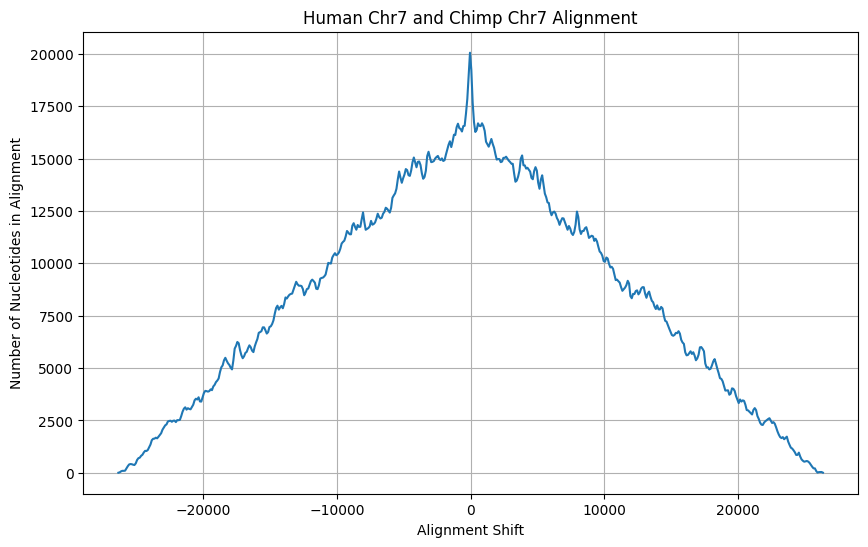

In [13]:
matches_title = 'Human Chr7 and Chimp Chr7 Alignment'
plot_alignment(splice1, global_alignment.matches, matches_title)

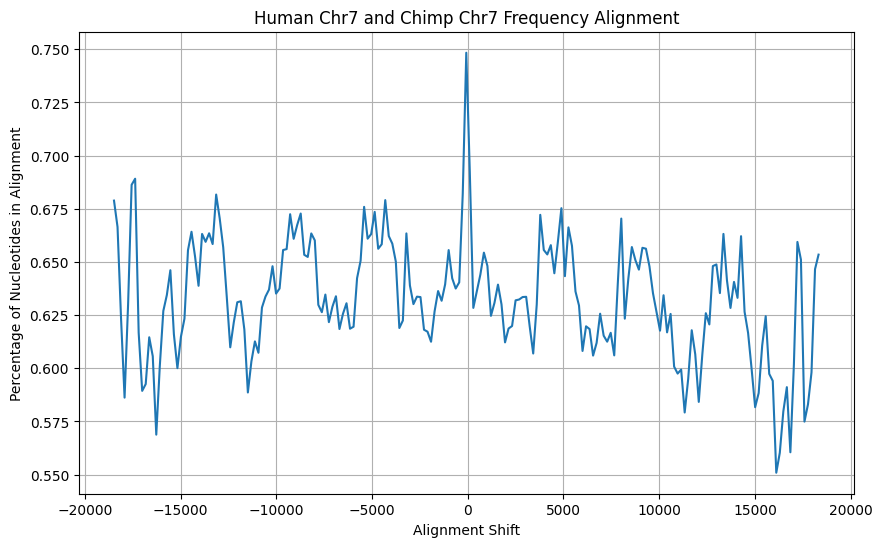

In [14]:
freq_title = 'Human Chr7 and Chimp Chr7 Frequency Alignment'
plot_frequency(global_alignment.freq, freq_title)